In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

0. Найти датасет для кластеризации: для этого берём датасет для мультиклассовой классификации и временно убираем метки классов. Эти метки классов пригодятся нам для оценки качества кластеризации. Хотя в реальной жизни такой роскоши скорее всего не будет, однако наличие априорного знания о кластерах позволит нам посчитать несколько дополнительных метрик.

В качестве данных был выбран набор содержащий сегментированые данные клиентов. Мы уберем в этом наборе колонку Segmentation и применим алгоритмы кластеризации на этом наборе. 
ссылка на более подробную информацию о наборе данных https://www.kaggle.com/abisheksudarshan/customer-segmentation

In [96]:
train = pd.read_csv('train.csv', sep=',', index_col='ID')
test = pd.read_csv('test.csv', sep=',', index_col='ID')

In [97]:
train.shape, test.shape

((8068, 10), (2627, 9))

In [98]:
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [99]:
train = train.drop(columns='Segmentation')
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
ID,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


In [100]:
train.isna().sum()

Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64

In [101]:
train.Ever_Married = train.Ever_Married.fillna(value=train.Ever_Married.mod)
train.Graduated = train.Graduated.fillna(value=train.Graduated.mod)
train.Work_Experience = train.Work_Experience.fillna(value=train.Work_Experience.median())
train.Family_Size = train.Family_Size.fillna(value=train.Family_Size.median())
train = train.dropna()

In [102]:
train.isna().sum()

Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64

In [103]:
train.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
ID,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6


In [104]:
train.Gender, _ = pd.factorize(train.Gender)
train.Ever_Married, _ = pd.factorize(train.Ever_Married)
train.Graduated, _ = pd.factorize(train.Graduated)
train = pd.get_dummies(train, columns=['Profession','Spending_Score','Var_1'])
train = train.astype(np.uint8)

In [105]:
train.head(5)

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
ID,,,,,,,,,,,,,,,,,,,,,
462809,0,0,22,0,1,4,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
462643,1,1,38,1,1,3,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
466315,1,1,67,1,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
461735,0,1,67,1,0,2,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
462669,1,1,40,1,1,6,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0


1. Производим иерархическую агломеративную кластеризацию (`scipy.cluster.hierarchy`), строим график-дендрограмму (`hierarchy.dendrogram`)

In [106]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [107]:
linked = linkage(train.values[:100], method="complete", metric='euclidean')

In [108]:
linked.shape

(99, 4)

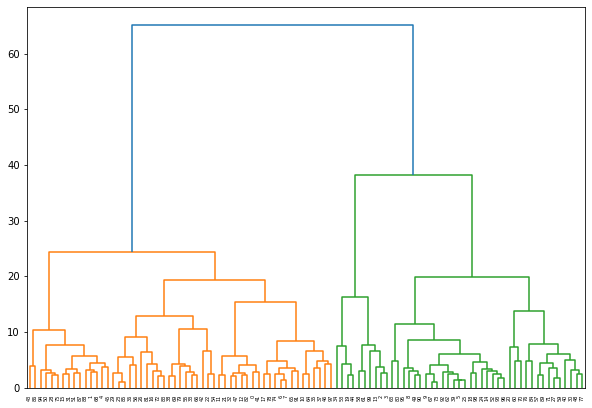

In [109]:
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()